In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
from GraphST import GraphST


/Users/abdullahalsakib/anaconda3/lib/python3.10/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [3]:
n_clusters = 7
sp_data_folder = '151673'
adata = sc.read_visium(sp_data_folder, count_file='filtered_feature_bc_matrix.h5', load_images=True)

adata.var_names_make_unique()
adata


/Users/abdullahalsakib/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/abdullahalsakib/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
device= torch.device('mps')

# define model
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [00:35<00:00, 17.00it/s]

Optimization finished for ST data!


In [5]:
adata


AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [6]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [7]:
from sklearn import metrics
df_meta = pd.read_csv('151673/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['Ground_Truth'] = df_meta_layer.values
adata = adata[~pd.isnull(adata.obs['Ground_Truth'])]    

In [8]:
ARI = metrics.adjusted_rand_score(adata.obs['mclust'], adata.obs['Ground_Truth'])
adata.uns['ARI'] = ARI
print('ARI:', ARI)

ARI: 0.612305085517117


/var/folders/zt/c6n2w1f53ngbmqr21hfs1yhw0000gn/T/ipykernel_86148/1165297297.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


/Users/abdullahalsakib/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/abdullahalsakib/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


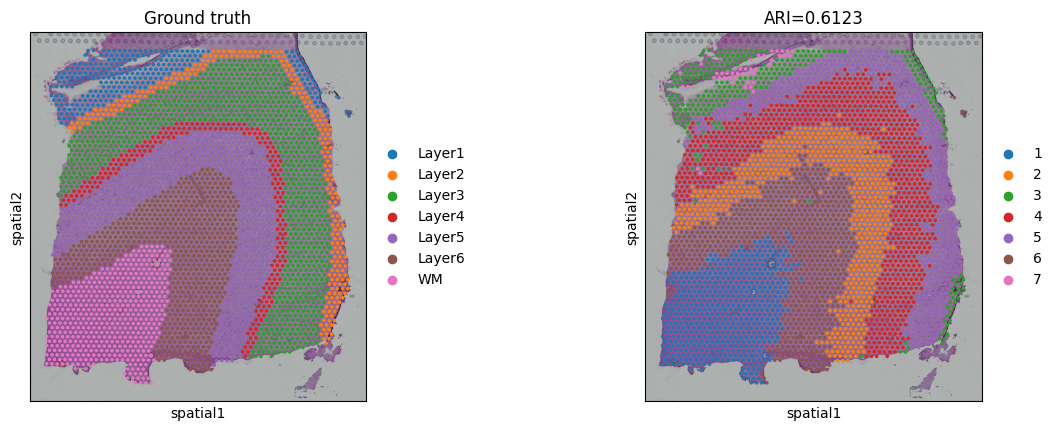

In [9]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["Ground_Truth", "mclust"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)